# 1. Introduction

# Mortgage Loan Default Prediction - Data Preprocessing
## Objective
The goal of this notebook is to preprocess a large dataset of mortgage loan applications to improve its quality and ensure the accuracy of a default prediction model.
Key steps include:
1. Data exploration
2. Handling missing values
3. Detecting and treating outliers
4. Cleaning noisy data
5. Feature engineering
6. Preparing the dataset for modeling


# 2. Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization defaults
sns.set(style="whitegrid")
# plt.style.use("ggplot")

# 3. Load Dataset

In [2]:
# Replace with the actual file path
data_path = "/Users/hoale/Code/Mortgage_Loan_Data_Preprocessing/Loan_Default.csv"
df = pd.read_csv(data_path)

# Display basic dataset information
print(f"Dataset shape: {df.shape}")
df.head()

# Quick summary
df.info()
df.describe()

Dataset shape: (148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  U

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [3]:
# Remove year and ID
df = df.drop(['year','ID'], axis=1)

In [4]:
# Convert columns with object datatype to categorical
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# 4. Exploratory Data Analysis (EDA)

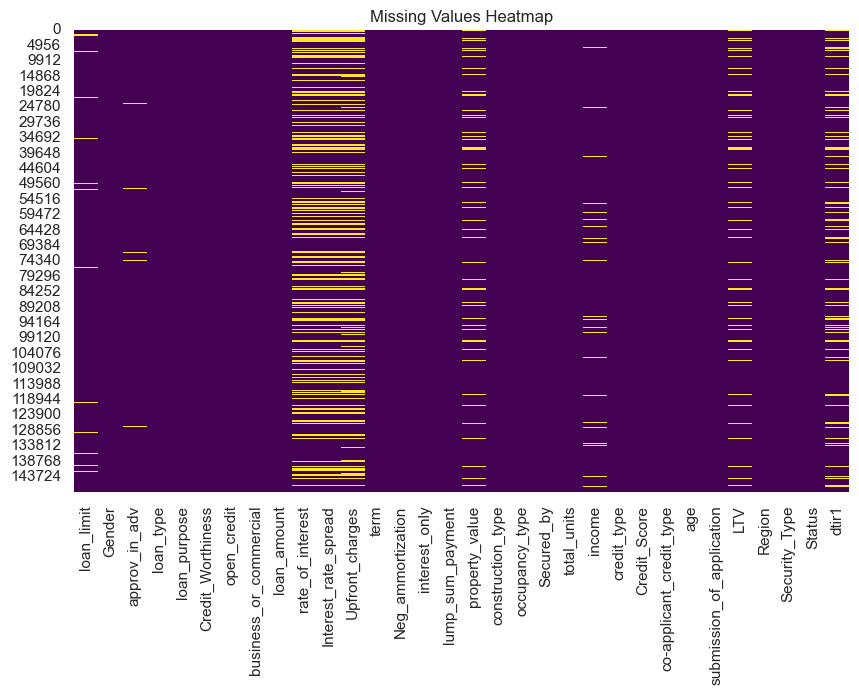

In [5]:
# Missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

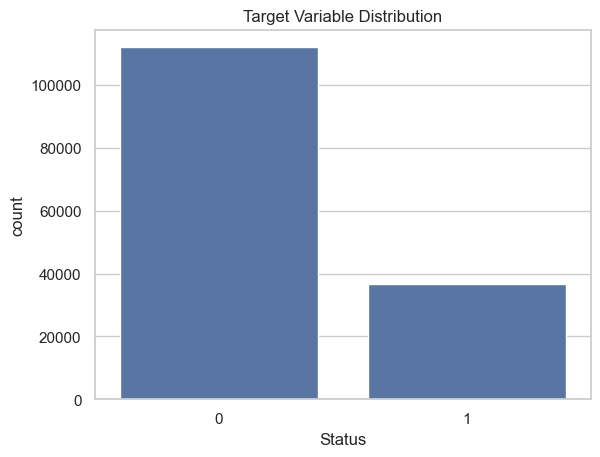

In [6]:
# Distribution of target variable
sns.countplot(x="Status", data=df)
plt.title("Target Variable Distribution")
plt.show()

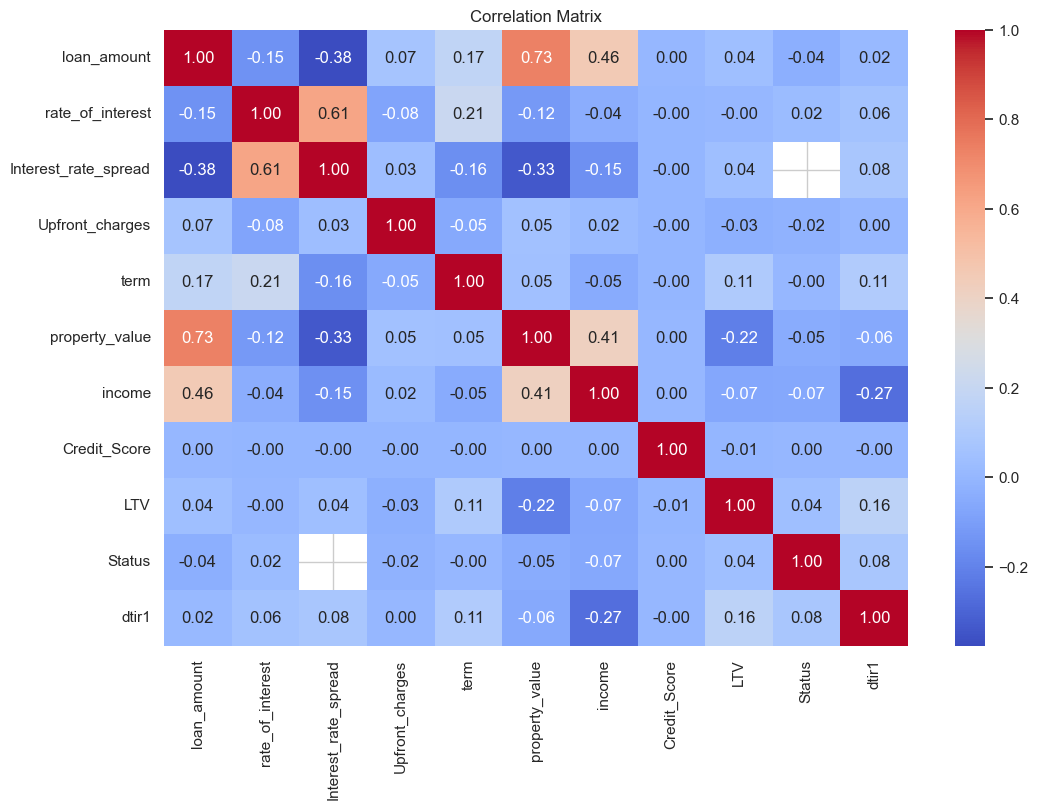

In [7]:
# Correlation matrix
plt.figure(figsize=(12, 8))
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 5. Handling Missing Values

In [8]:
# Check missing values percentage
missing_percent = df.isnull().mean() * 100
print("Missing Values Percentage:\n", missing_percent[missing_percent > 0])

Missing Values Percentage:
 loan_limit                    2.249277
approv_in_adv                 0.610749
loan_purpose                  0.090133
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
property_value               10.155378
income                        6.154571
age                           0.134526
submission_of_application     0.134526
LTV                          10.155378
dtir1                        16.224524
dtype: float64


Maximum missing values percentage is 27%. We will not drop any columns but instead impute them with appropriate values. 

In [9]:
# Impute numerical columns with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Impute categorical columns with mode
cat_cols = df.select_dtypes(include=["category"]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# 6. Outlier Detection and Treatment

In [10]:
# Using IQR for outlier detection
def treat_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)

for col in num_cols:
    treat_outliers_iqr(col)

# 7. Data Cleaning

In [11]:
# Removing duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

# Convert categorical columns to lowercase (standardization)
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower())

Shape after removing duplicates: (148670, 32)


# 8. Feature Engineering

In [12]:
# Log-transform skewed numerical features
from scipy.stats import skew

skewed_features = df[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.75].index

for col in high_skew:
    df[col] = np.log1p(df[col])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

/var/folders/b9/_pzwgqx90zl_0smjhfdfr33r0000gn/T/ipykernel_64787/1422911261.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewed_features = df[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)


# 9. Data Transformation

In [13]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Dataset after scaling and encoding:")
df.head()

Dataset after scaling and encoding:


,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,...,age_45-54,age_55-64,age_65-74,age_<25,age_>74,submission_of_application_to_inst,Region_north,Region_north-east,Region_south,Security_Type_indriect
0,-1.250178,-0.073337,-0.077288,-0.126508,0.0,-2.239520,-1.124731,0.502357,1.498275,0.0,...,False,False,False,False,False,True,False,False,True,False
1,-0.717472,-0.073337,-0.077288,-0.126508,0.0,0.053433,-0.045668,-1.275413,0.122945,0.0,...,False,True,False,False,False,True,True,False,False,False
2,0.466318,1.183338,-0.538556,-1.035253,0.0,0.406950,0.615071,1.158234,0.407643,0.0,...,False,False,False,False,False,True,False,False,True,False
3,0.762266,0.499884,0.626728,-0.126508,0.0,0.875992,0.846709,-0.973365,-0.212769,0.0,...,True,False,False,False,False,False,True,False,False,False
4,2.182814,-0.051290,-0.286118,-1.305409,0.0,1.132480,0.714081,-0.843916,1.099411,0.0,...,False,False,False,False,False,False,True,False,False,False


# 10. Save the Preprocessed Dataset

In [ ]:
# Save the preprocessed dataset
df.to_csv("preprocessed_dataset.csv", index=False)